In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import shapefile
from collections import Counter
from shapely.geometry import shape, Point
from rtree import index
from matrix_factorization import *
from model_evaluations import *
import random
from secrets import randbelow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

pip install geopandas didn't work and neither did the conda forge version
for some reason. I used this instead.
https://geoffboeing.com/2014/09/using-geopandas-windows/.


1. make a virtual environment with the whole anaconda: conda create --name geoproject anaconda.
2. Install wheels as so without having to do the PATH part.

3. Install shapafile with pip install pyshp. 

Geopandas is able to read all the gis files and you can change the coordinate reference system easily from it. http://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1

## Prep Foursquare data from Kaggle. Categorize coordinates into their respective NYC borough by using boundary polygons from https://geo.nyu.edu/catalog/nyu-2451-34563. Coordinates not in any of these polygons are in New Jerse, on bridges, and other various locations. They will be filtered out.

The newly made dataframe will be saved as a pickle for fast data ingestion.

# Prepare the polygon neighborhood boundaries

Download Polygon Data link:

https://geo.nyu.edu/catalog/nyu-2451-34563

In [2]:
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\nyc-polygons\neighborhoods-high-res-spatial\ZillowNeighborhoods-NY.shp'

# Use proper Coordinate Reference Systems coordinates Latitude/Longitude.
# http://geopandas.org/projections.html
boroughs = geopandas.read_file(file_path).to_crs({'init': 'epsg:4326'})
raw_nyc = boroughs[boroughs['City']=='New York']

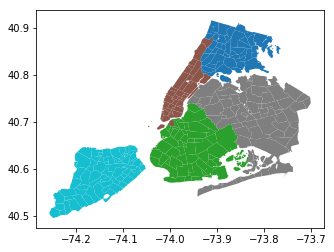

In [3]:
raw_nyc.plot('County', categorical=True)
plt.show()

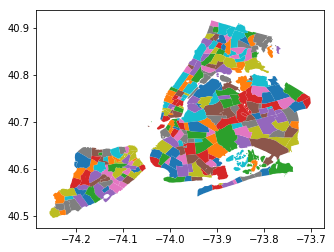

In [4]:
raw_nyc.plot('Name', categorical=True)
plt.show()

https://stackoverflow.com/questions/23871409/optimal-way-of-aggregating-geographic-points-with-python-shapely/24114565#24114565

In [5]:
# 1. Drop staten island and bronx because we don't have enough FS data for them.
# 2. Reset the index
raw_nyc = raw_nyc[(raw_nyc['County']!='Richmond') & (raw_nyc['County']!='Bronx')]#.reset_index(drop=True, inplace=True)
raw_nyc.reset_index(drop=True, inplace=True)

### Find duplicate neighborhoods
[k for k, v in Counter(raw_nyc['Name']).items() if v ==2]

['Murray Hill', 'Vinegar Hill', 'Brooklyn Heights']

In [6]:
# 'Brooklyn Heights' have duplicate except different counties. 
# It's in brooklyn so drop the new york county row.
raw_nyc[raw_nyc['Name']=='Brooklyn Heights']#.iloc[1]['geometry']
raw_nyc.drop(116, inplace=True)

In [7]:
# 'Murray Hill' neighborhoods have the same name but are in different boroughs.
# Change the Name of the Queens Murray Hill to 'Murray Hill Queens'
raw_nyc[raw_nyc['Name']=='Murray Hill']
raw_nyc.loc[59, 'Name'] = 'Murray Hill Queens'

In [8]:
# Vinegar Hill has duplicate entries with one of the
# entries in the wrong County; New York. I will delete
# that entry because the neighborhood is in Brooklyn.

raw_nyc[raw_nyc['Name']=='Vinegar Hill']
raw_nyc.drop(84, inplace=True)

# Reset the index.
nyc_polygons = raw_nyc.reset_index(drop=True)

# Make room for memory.
del raw_nyc

#### Use nyc neighborhood polygons to assign foursquare location to it's neighborhood

In [9]:
# It will take a 1-2 minutes to load because of the data parser.
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\original-data\dataset_TSMC2014_NYC.csv'

raw_fs = pd.read_csv(file_path, parse_dates=['utcTimestamp'])
# Make a coordinate tuple. This is the format that compatible with the shape file read by geopandas.
raw_fs['coordinates'] = list(zip(raw_fs.loc[:,'longitude'], raw_fs.loc[:, 'latitude']))

In [10]:
# Make coordinates into Shapely points so they can be placed in polygons.
raw_fs['point'] = raw_fs['coordinates'].apply(lambda x: Point(x))

In [11]:
# Make the nyc polygons, from beginning of notebook, into a list.
poly_list = nyc_polygons['geometry'].tolist()

# Create rtree index finding points to it's neighborhood polygon.
idx = index.Index()
for pos, poly in enumerate(poly_list):
    idx.insert(pos, poly.bounds)

In [12]:
def find_hood_ind(p):
    '''Finds which polygon the point belongs to in the polygon list.
    Arguments:
    p -- Shapely point
    
    Return:
    hood_indexes -- list, list of polygon indexes the point is in.
    '''
    hood_indexes = [i for i in idx.intersection(p.coords[0]) if p.within(poly_list[i])]
    
    return hood_indexes

In [13]:
hood_ind = raw_fs['point'].apply(find_hood_ind)

In [14]:
# Make a ind to neighborhood key value lookup pair.
# This dictionary will also be used below when placing the 
# label location data into neighborhoods.
ind2hood = dict(zip(np.arange(len(poly_list)), nyc_polygons.loc[:, 'Name']))

# Use ind2hood index to convert the indexes to neighborhood names.
raw_fs['neighborhood'] = ['Other' if i == [] else ind2hood[i[0]] for i in hood_ind]

In [15]:
# Find indexes for points that don't belong to any neighborhood polyogons
# delete them because they will not have any crime data.
no_neighborhood = np.where(raw_fs['neighborhood']=='Other')[0]
raw_fs.drop(raw_fs.index[no_neighborhood], inplace=True)
raw_fs.reset_index(drop=True, inplace=True)

In [16]:
# Turn neighborhood column into one-hots.
fs = pd.concat([raw_fs, pd.get_dummies(raw_fs['neighborhood'])], axis=1)

del raw_fs

In [ ]:
# Save dataframe as pickle so you don't have to re-run all the code above again.
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\cleaned_foursquare_df.pkl'
pd.to_pickle(fs, file_path)

# Clean and Set up theft labels per neighborhood

NYPD Crime Data download link:

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [17]:
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\original-data\NYPD_Complaint_Data_Historic.csv'
raw_crime_data = pd.read_csv(file_path)

C:\Users\DS\Anaconda3\envs\dynamic\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# There are years that are wrong dates such as 1015 which will throw errors.
# I 'coerce' the parsing and these wrong ones will turn into 'NaT'.
raw_crime_data['Date'] = pd.to_datetime(raw_crime_data['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')

# Do the same with time and then use 'dt.time' to get just the time. There are 24:00:00 which
# doesn't really exist so let's 'coerce' them to 'NaT' because I don't know if they are meant to be
# on the next day or the current day of the date.
raw_crime_data['Time'] = pd.to_datetime(raw_crime_data['CMPLNT_TO_TM'], 
                                        format='%H:%M:%S', errors='coerce').dt.time

In [19]:
# Drop the 'NaT''s from 'Time' and 'Date' columns
drop_indexes_date = np.where(raw_crime_data['Date'].isnull())[0]
drop_indexes_time = np.where(raw_crime_data['Time'].isnull())[0]


drop_list = np.concatenate((drop_indexes_date, drop_indexes_time), axis=0)

raw_crime_data.drop(drop_list, axis=0, inplace=True)

del drop_list, drop_indexes_date, drop_indexes_time

In [20]:
# Filter rows from range 04-03-2012 and 02-06-2013 which is our FourSquare data range.
raw_crime_data = raw_crime_data.set_index('Date').loc['20120403': '20130216'].sort_index()

In [21]:
# Reset index to start combining 'Date', and 'Time' to make a timestamp.
raw_crime_data = raw_crime_data.reset_index()

# Couldn't figure out how to combine the 'Date' and 'Time' datetime objects together
# so I turned them back into string and combined them.
# I had to access 'dt' first.
raw_crime_data['Date'] = raw_crime_data['Date'].dt.strftime('%Y-%m-%d')

# I couldn't do this the same way as above and had to use lambda instead to get it to work.
raw_crime_data['Time'] = raw_crime_data['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

In [22]:
raw_crime_data['utcTimestamp'] = pd.to_datetime(raw_crime_data['Date'] + ' ' + raw_crime_data['Time'])

In [23]:
# Grand Larceny (theft df). Theft had a low p-value in the research paper.
# Therfore, we will keep things simple and just build models from theft labels.
theft_df = raw_crime_data[raw_crime_data['OFNS_DESC']=='GRAND LARCENY']

del raw_crime_data

In [24]:
### Start using the longitude and latitude to place the crime in it's neighborhood.
theft_df['coordinates'] = list(zip(theft_df.loc[:,'Longitude'], theft_df.loc[:, 'Latitude']))

# Make coordinates into Shapely points so they can be placed in polygons.
theft_df['point'] = theft_df['coordinates'].apply(lambda x: Point(x))

theft_hood_ind = theft_df['point'].apply(find_hood_ind)

In [25]:
# Use ind2hood dictionary to convert the indexes to neighborhood names.

theft_df['neighborhood'] = ['Other' if i == [] else ind2hood[i[0]] for i in theft_hood_ind]

In [26]:
# Find indexes for points that don't belong to any neighborhood polyogons
# delete them because they will not have any foursquare data.
outside_neighborhood = np.where(theft_df['neighborhood']=='Other')[0]
theft_df.drop(theft_df.index[outside_neighborhood], inplace=True)
theft_df.reset_index(drop=True, inplace=True)

In [27]:
# Turn the neighborhood column into one-hots.
theft_group = theft_df.groupby([pd.Grouper(key='utcTimestamp', freq='3H'), 'neighborhood']).count()
cleaned_theft_labels = theft_group.iloc[:,0].unstack(level=1).fillna(0)

del theft_group

In [ ]:
# Save as pickle for faster loading
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\cleaned_neighborhood_theft_labels.pkl'
pd.to_pickle(cleaned_theft_labels, file_path)

-----------------------------------
-----------------------------------
# Cleaning done.
# Starting the dynamic features.

In [28]:
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\cleaned_foursquare_df.pkl'

fs = pd.read_pickle(file_path)

There are 2547 3-hour time intervals that have at least regional one datapoint in this dataset. If there are no events in the time intervals when grouping, the new dataframe will skip over the no-event time interval. Since I have many dynamic features that could possibly have different missing data, I will keep doing a "left" merge to the base 2547 rows 3-hour time interval frame so I have one consistent dimension shape.

In [29]:
base_fs = fs.groupby(pd.Grouper(key='utcTimestamp', freq='3H'))['userId'].count().reset_index().rename(columns={'userId': 'count'})
base_fs.shape

(2547, 2)

## Visitor Count: Number of unique users in region r at time interval t.

In [30]:
visitor = fs.groupby([pd.Grouper(key='utcTimestamp', freq='3H'),
                      'neighborhood'])['userId'].nunique().unstack(level=1).reset_index()
visitor_count = pd.merge(base_fs, visitor, on='utcTimestamp', how='left').drop('count', axis=1)
visitor_count = visitor_count.set_index('utcTimestamp')

# Make space for memory
del visitor

print('Number of time intervals: ', visitor_count.shape[0])
visitor_count.head()

Number of time intervals:  2547


,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,Battery Park,Bay Ridge,Bay Terrace,Bayside,Bedford Stuyvesant,...,Utopia,Vinegar Hill,Washington Heights,West Village,Whitestone,Williamsburg,Windsor Terrace,Wingate,Woodhaven,Woodside
utcTimestamp,,,,,,,,,,,,,,,,,,,,,
2012-04-03 18:00:00,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2012-04-03 21:00:00,NaN,4.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,...,NaN,NaN,3.0,10.0,2.0,5.0,NaN,NaN,NaN,2.0
2012-04-04 00:00:00,NaN,2.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2.0,...,NaN,NaN,3.0,3.0,3.0,12.0,NaN,NaN,NaN,NaN
2012-04-04 03:00:00,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,NaN,1.0
2012-04-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Observation Frequency: Number of check-ins in region r and its neighborhood at        time interval t.

In [31]:
obs = fs.groupby([pd.Grouper(key='utcTimestamp', freq='3H'),
                  'neighborhood'])['userId'].count().unstack(level=1).reset_index()
obs_freq = pd.merge(base_fs, obs, on='utcTimestamp', how='left').drop('count', axis=1).set_index('utcTimestamp')

# Make space for memory
del obs

print('Number of time intervals: ', obs_freq.shape[0]) 

Number of time intervals:  2547


## Visitor entropy: Diversity of visitors in a location with respect to their visits.

In [32]:
# You have do merge the user ids total number of visits to the region and then divide the 
# 2 columns to get the probability that they will be there at that time.
visits_r_t = fs.groupby(['neighborhood', pd.Grouper(key='utcTimestamp',
                                             freq='3H'), 'userId']).count().iloc[:,0]

visits_r_t.head()

neighborhood  utcTimestamp         userId
Arverne       2012-04-04 15:00:00  194       2
              2012-04-07 12:00:00  194       1
                                   758       1
              2012-04-07 15:00:00  380       3
              2012-04-08 21:00:00  380       1
Name: venueId, dtype: int64

In [33]:
# number of checkins per user
total_user_checkins = fs.groupby(['userId']).count().iloc[:,0]
total_user_checkins.head()

userId
1    106
2    122
3    116
4    167
5     28
Name: venueId, dtype: int64

In [34]:
# Join on user id and now you have userid number of checkins in that time interval and 
# a column that shows their total checkins.
fs_visits_r_t = pd.merge(visits_r_t.reset_index(), total_user_checkins.reset_index(),
                   on=['userId']).rename(columns={'venueId_x': 'reg_time_visits',
                                                  'venueId_y': 'total_visits'})

# Make room for memory
del visits_r_t, total_user_checkins

fs_visits_r_t.head()

,neighborhood,utcTimestamp,userId,reg_time_visits,total_visits
0,Arverne,2012-04-04 15:00:00,194,2,116
1,Arverne,2012-04-07 12:00:00,194,1,116
2,Arverne,2012-04-09 12:00:00,194,1,116
3,Arverne,2012-04-14 21:00:00,194,1,116
4,Arverne,2012-06-11 21:00:00,194,1,116


In [35]:
# Get the probability that user will be at region at time interval.
fs_visits_r_t['probability'] = fs_visits_r_t['reg_time_visits']/fs_visits_r_t['total_visits']
fs_visits_r_t.head()

,neighborhood,utcTimestamp,userId,reg_time_visits,total_visits,probability
0,Arverne,2012-04-04 15:00:00,194,2,116,0.017241
1,Arverne,2012-04-07 12:00:00,194,1,116,0.008621
2,Arverne,2012-04-09 12:00:00,194,1,116,0.008621
3,Arverne,2012-04-14 21:00:00,194,1,116,0.008621
4,Arverne,2012-06-11 21:00:00,194,1,116,0.008621


In [36]:
fs_visits_r_t['used_for_visitor_entropy'] = [-x*np.log2(x) for x in fs_visits_r_t['probability']]
fs_visits_r_t.head()

,neighborhood,utcTimestamp,userId,reg_time_visits,total_visits,probability,used_for_visitor_entropy
0,Arverne,2012-04-04 15:00:00,194,2,116,0.017241,0.101000
1,Arverne,2012-04-07 12:00:00,194,1,116,0.008621,0.059121
2,Arverne,2012-04-09 12:00:00,194,1,116,0.008621,0.059121
3,Arverne,2012-04-14 21:00:00,194,1,116,0.008621,0.059121
4,Arverne,2012-06-11 21:00:00,194,1,116,0.008621,0.059121


In [37]:
# Sum all the individual user entropys for region r and time interval t.
incomplete_entropy_df = fs_visits_r_t.groupby(['neighborhood', 
                                    'utcTimestamp'])['used_for_visitor_entropy'].sum().unstack(level=0).reset_index()

visitor_entropy = pd.merge(base_fs, incomplete_entropy_df, 
                           how='left', on='utcTimestamp').drop('count', axis=1).set_index('utcTimestamp')

# Make space in memory.
del incomplete_entropy_df

print('Number of time intervals: ', visitor_entropy.shape[0])
visitor_entropy.head()

Number of time intervals:  2547


,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,Battery Park,Bay Ridge,Bay Terrace,Bayside,Bedford Stuyvesant,...,Utopia,Vinegar Hill,Washington Heights,West Village,Whitestone,Williamsburg,Windsor Terrace,Wingate,Woodhaven,Woodside
utcTimestamp,,,,,,,,,,,,,,,,,,,,,
2012-04-03 18:00:00,NaN,0.123874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062951,...,NaN,NaN,NaN,0.041809,NaN,0.021169,NaN,NaN,NaN,NaN
2012-04-03 21:00:00,NaN,0.178582,NaN,NaN,0.040533,NaN,NaN,0.035835,NaN,0.097399,...,NaN,NaN,0.117417,0.508636,0.066212,0.270642,NaN,NaN,NaN,0.090173
2012-04-04 00:00:00,NaN,0.082445,NaN,0.043792,0.040533,NaN,NaN,0.023753,0.064917,0.073061,...,NaN,NaN,0.143015,0.216840,0.082992,0.432524,NaN,NaN,NaN,NaN
2012-04-04 03:00:00,NaN,0.018853,0.018853,NaN,0.020188,NaN,NaN,NaN,0.036452,0.063945,...,NaN,NaN,0.021041,0.039012,0.122325,0.049930,NaN,NaN,NaN,0.029033
2012-04-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Region Popularity: Assess popularity of region r at time interval t.

In [38]:
# Count how many total checkins at all time intervals 
all_checkins_at_time = fs.groupby(pd.Grouper(key='utcTimestamp', freq='3H'))['userId'].count()

# Divide regions checkins at time interval by total checkins at that time interval.
region_popularity = obs_freq.divide(all_checkins_at_time, axis=0)


del all_checkins_at_time

print('Number of time intervals: ', region_popularity.shape[0])
region_popularity.head()

Number of time intervals:  2547


,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,Battery Park,Bay Ridge,Bay Terrace,Bayside,Bedford Stuyvesant,...,Utopia,Vinegar Hill,Washington Heights,West Village,Whitestone,Williamsburg,Windsor Terrace,Wingate,Woodhaven,Woodside
utcTimestamp,,,,,,,,,,,,,,,,,,,,,
2012-04-03 18:00:00,NaN,0.010638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021277,...,NaN,NaN,NaN,0.005319,NaN,0.005319,NaN,NaN,NaN,NaN
2012-04-03 21:00:00,NaN,0.015291,NaN,NaN,0.003058,NaN,NaN,0.006116,NaN,0.009174,...,NaN,NaN,0.012232,0.030581,0.009174,0.024465,NaN,NaN,NaN,0.006116
2012-04-04 00:00:00,NaN,0.008969,NaN,0.004484,0.004484,NaN,NaN,0.004484,0.004484,0.008969,...,NaN,NaN,0.013453,0.017937,0.013453,0.089686,NaN,NaN,NaN,NaN
2012-04-04 03:00:00,NaN,0.009346,0.009346,NaN,0.009346,NaN,NaN,NaN,0.009346,0.009346,...,NaN,NaN,0.009346,0.009346,0.028037,0.028037,NaN,NaN,NaN,0.009346
2012-04-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visitor Ratio:


To group, count, and regroup, order by descending and take top 4


https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups

In [39]:
# Groupby 'userId' and 'venueId'. Count to see how many times a user checked in that venueId. This will make a series.
user_venue_count = fs.groupby(['userId', 'venueId']).count().iloc[:,-1]

In [40]:
# Now that you have the count for venue checkins by each user you will re-group by 'userId' and apply a function 
# to each 'userId' grouping (sort descending and keep top 4) to get back the top 4 visited venues for that user.
user_grouping = user_venue_count.groupby(level=0, group_keys=False)  # When calling apply, add group keys argument to prevent key appearing twice IT.
user_top_venues = user_grouping.apply(lambda x: x.sort_values(ascending=False).head(4))

In [41]:
# We need the timestamp and borough of all the users top 4 checkins.
top_4_full_df = pd.merge(user_top_venues.reset_index(), fs, how='left', on=['userId', 'venueId'])

# Drop duplicates so I get the first visit of the users top 4 checkins.
first_visit = top_4_full_df.drop_duplicates(['userId', 'venueId'])
incomplete_visit_df = first_visit.groupby([pd.Grouper(key='utcTimestamp', freq='3H'), 'neighborhood']).count().iloc[:, 0].unstack(level=1)

##################### SANITY CHECK
# # All that is commented out, to make sure the time stamps are ascending since I will drop duplicates.
# # It seems like the timestamps are in order but just in case they are not I will order them because I
# # am going to remove the duplicates based on userId and venueId so it will only keep the first occurence
# # which gives up the first checkin timestamp.
# sort_df = top_4_full_df.set_index(['userId', 'venueId']).groupby(level=[0,1], group_keys=False).apply(lambda x: x.sort_values(by='utcTimestamp'))
# first_visit = sort_df.reset_index().drop_duplicates(['userId', 'venueId'])

# # Group by time stamp and neighborhood. Take a count and unpivot the column so that we have the 
# # have the first time occurences of the top 4 userid visits by venue. The rows containing all zeros are excluded so
# # this needs to be joined back to the base df so we have a row for each time interval.
# incomplete_visit_df = first_visit.groupby([pd.TimeGrouper(key='utcTimestamp', freq='3H'), 'borough']).count().iloc[:, 0].unstack(level=1)
######################

# Join
new_user_venue_checkins = pd.merge(base_fs, incomplete_visit_df.reset_index(), how='left', on='utcTimestamp').drop('count', axis=1)

# Calculate visitor ratio by dividing by observation frequency for that region at that time interval.
visitor_ratio = new_user_venue_checkins.set_index('utcTimestamp')/obs_freq

# Make space for memory.
del user_venue_count, user_grouping, user_top_venues, top_4_full_df
del first_visit,incomplete_visit_df, new_user_venue_checkins

print('Number of time intervals: ', visitor_ratio.shape[0])
visitor_ratio.head()

Number of time intervals:  2547


,Arverne,Astoria,Astoria Heights,Auburndale,Bath Beach,Battery Park,Bay Ridge,Bay Terrace,Bayside,Bedford Stuyvesant,...,Utopia,Vinegar Hill,Washington Heights,West Village,Whitestone,Williamsburg,Windsor Terrace,Wingate,Woodhaven,Woodside
utcTimestamp,,,,,,,,,,,,,,,,,,,,,
2012-04-03 18:00:00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,...,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-03 21:00:00,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,0.40,0.333333,0.125000,NaN,NaN,NaN,0.5
2012-04-04 00:00:00,NaN,0.5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.50,...,NaN,NaN,0.666667,0.25,0.666667,0.300000,NaN,NaN,NaN,NaN
2012-04-04 03:00:00,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.00,...,NaN,NaN,NaN,NaN,0.666667,0.333333,NaN,NaN,NaN,NaN
2012-04-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## All dynamic features done except for one of them. Concat them all together, fill NaN with 0, and do the matrix factorization to make dynamic features.

In [42]:
# Concat features and fill NaN with 0.
original_features_df = pd.concat([visitor_count, 
           obs_freq,
           visitor_entropy,
           visitor_ratio,
           region_popularity], axis=1).fillna(0)

In [43]:
# # Drop low activity hours (less than 20 obs freq and low activity neighborhoods)
# number_neighborhoods = obs_freq.columns.shape[0]
# neighborhood_names = obs_freq.columns
# low_activity_neighborhoods = neighborhood_names[obs_freq.fillna(0).sum()<300]
# low_activity_hour_indexes = obs_freq[obs_freq.fillna(0).sum(axis=1)<20].index
# original_features_df.drop(low_activity_neighborhoods, axis=1, inplace=True)
# original_features_df.drop(low_activity_hour_indexes, inplace=True)

# Drop low activity hours (less than 20 obs freq and low activity neighborhoods)
number_neighborhoods = obs_freq.columns.shape[0]
neighborhood_names = obs_freq.columns
low_activity_hour_indexes = obs_freq[obs_freq.fillna(0).sum(axis=1)<20].index
original_features_df.drop(low_activity_hour_indexes, inplace=True)


low_activity_neighborhoods = neighborhood_names[obs_freq.fillna(0).sum()<300]
original_features_df.drop(low_activity_neighborhoods, axis=1, inplace=True)

Loss after epoch 0: 384990.55172
Loss after epoch 10: 138499.33465


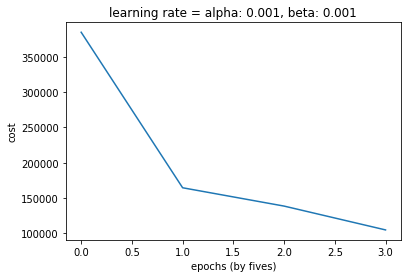

In [44]:
columns = original_features_df.columns
index = original_features_df.index
K = 250  # Shape of second dimension of matrices. (time interval, K) x (K, regions)
dynamic_features, _ = dynamic_feature_estimation(original_features_df.fillna(0).values, K=K, alpha=0.001, beta=0.001, epochs=20, print_cost=True)

In [45]:
# Rebuild the df
full_dynamic_df = pd.DataFrame(dynamic_features, columns=columns, index=index)

### Prep Labels and find city to build model and predictions

In [46]:
file_path = r'C:\Users\DS\Desktop\dynamic-features\data\cleaned_neighborhood_theft_labels.pkl'
theft_df = pd.read_pickle(file_path)

# The author said the crime labels are binary so I make them binary.
theft_df[theft_df>1]=1

## Sanity check
# np.where(np.asarray(theft_df)>1)

# Get the time indexes that both X and Y df's match on, 'inner', so
# I can start deciding which city I will run the model and can then actually
# build the model.
timestamp_indexes_keep = pd.merge(full_dynamic_df, theft_df,
                                  on='utcTimestamp').index

In [47]:
non_dynamic_df = original_features_df.loc[timestamp_indexes_keep]
dynamic_df = full_dynamic_df.loc[timestamp_indexes_keep]
theft_df = theft_df.loc[timestamp_indexes_keep]

del timestamp_indexes_keep, original_features_df, full_dynamic_df

In [48]:
# Calculate the percent that each neighborhood is labeled.
neighborhoods = theft_df.columns
percent_labeled = [int((sum(theft_df.loc[:,hood])/theft_df.shape[0])*100) for hood in neighborhoods]

for city, percent in list(zip(neighborhoods, percent_labeled)):
    print('{}%\t{}'.format(percent, city))

0%	Arverne
17%	Astoria
0%	Astoria Heights
1%	Auburndale
7%	Bath Beach
1%	Battery Park
5%	Bay Ridge
0%	Bay Terrace
5%	Bayside
24%	Bedford Stuyvesant
0%	Belle Harbor
2%	Bellerose
5%	Bensonhurst
0%	Bergen Beach
0%	Blissville
2%	Boerum Hill
6%	Borough Park
0%	Breezy Point
1%	Briarwood
5%	Brighton Beach
0%	Broad Channel
2%	Brooklyn Heights
5%	Brownsville
10%	Bushwick
0%	Cambria Heights
8%	Canarsie
1%	Carnegie Hill
2%	Carroll Gardens
5%	Central Park
21%	Chelsea
3%	Chinatown
11%	Clinton
4%	Clinton Hill
0%	Cobble Hill
3%	College Point
0%	Columbia Street Waterfront District
7%	Columbus Circle
9%	Coney Island
5%	Corona
15%	Crown Heights
1%	DUMBO
2%	Douglaston-Little Neck
9%	Downtown
3%	Dyker Heights
8%	East Elmhurst
13%	East Flatbush
15%	East Harlem
22%	East New York
15%	East Village
17%	Elmhurst
4%	Far Rockaway
11%	Financial District
18%	Flatbush
24%	Flatiron District
7%	Flatlands
0%	Floral park
0%	Floyd Bennett Field
9%	Flushing
0%	Flushing Meadows Corona Park
7%	Forest Hills
0%	Forest Hills G

In [49]:
def neighborhood_evaluation(neighborhood):
    '''The neighborhoods features are used to evaluate theft predictions with 
    LR, Random Forest, and fully connected 1-layer Neural Network and to compare original 
    sparse features, sparse scaled, dynamic features, and dynamic scaled. The evaluation 
    metrics are auc, f1, and accuracy. This function can be easily changed to return 
    predictions, auc, f1, and accuracy for all the differentcombinations of sparse, dynamic, 
    and scaled training data.
    
    Arguments:
    neighborhood -- str, neighborhood name located in columns dataframe.
    
    Return:
    None
    '''
    
    neighborhood_sparse_features = non_dynamic_df.loc[:, neighborhood]
    neighborhood_dynamic_features = dynamic_df.loc[:, neighborhood]
    neighborhood_labels = theft_df.loc[:, neighborhood]

    print('\n\nResults for {}:'.format(neighborhood))
    print('Frequency of thefts in {}: {}'.format(neighborhood, Counter(neighborhood_labels)))
    
    # The research paper uses a 50%/50% balanced set for the model
    # so I will make apply under-sampling techniques and drop some no-crime data.           
    theft_keep_indexes = np.where(neighborhood_labels==1)[0]
    non_theft_indexes = random.sample(population=list(np.where(neighborhood_labels==0)[0]), k=sum(neighborhood_labels==1))

    # Get the indexes of the rows that I will keep for model training.
    X_indexes = np.concatenate((non_theft_indexes, theft_keep_indexes), axis=0)
    # sort X_indexes
    X_indexes.sort()
    
    sparse_X = neighborhood_sparse_features.iloc[X_indexes]
    dynamic_X = neighborhood_dynamic_features.iloc[X_indexes]
    Y = neighborhood_labels.iloc[X_indexes]
    
    print('Frequency of thefts in {} after under-sampling: {}'.format(neighborhood, Counter(Y)))

    # Secured random selection which will be used to make
    # comparisons between sparse, dynamic, and scaled features.
    random_seed = randbelow(4294967000)
    X_train_sparse, X_test_sparse, Y_train, Y_test = train_test_split(sparse_X, Y, test_size=0.30, random_state=random_seed)
    X_train_dynamic, X_test_dynamic, Y_train, Y_test = train_test_split(dynamic_X, Y, test_size=0.30, random_state=random_seed)

    ## Making scaled sparse features (whole dataset)
    scalar = StandardScaler().fit(sparse_X)
    sparse_X_scaled = scalar.transform(sparse_X)

    # sparse scaled training and test set
    scalar = StandardScaler().fit(X_train_sparse)
    X_train_sparse_scaled = scalar.transform(X_train_sparse)
    X_test_sparse_scaled = scalar.transform(X_test_sparse)

    ### Making scaled dynamic features (whole dataset)
    scalar = StandardScaler().fit(dynamic_X)
    dynamic_X_scaled = scalar.transform(dynamic_X)

    # dynamic scaled training and test set
    scalar = StandardScaler().fit(X_train_dynamic)
    X_train_dynamic_scaled = scalar.transform(X_train_dynamic)
    X_test_dynamic_scaled = scalar.transform(X_test_dynamic)
    
    print('\nCross Validation Scores were taken from original sparse features and dynamic features to ')
    print('evaluate dynamic feature performance. The features were also scaled to check if scaling helped performance.')
    print('The order of features used for cross-validation are as follows:') 
    print('Sparse, Dynamic, Sparse scaled, Dynamic scaled')
    print('\n')

    ### Modelling
    ## SVM
    # Sparse vs dynamic
    svm_sparse_pred, svm_sparse_auc, svm_sparse_f1, accuracy_sparse_svm = svm_evaluation(sparse_X, Y, X_train_sparse, X_test_sparse, Y_train, Y_test)
    svm_pred, svm_auc, svm_f1, accuracy_svm =svm_evaluation(dynamic_X, Y, X_train_dynamic, X_test_dynamic, Y_train, Y_test)

    # Sparse scaled vs dynamic scaled
    svm_sparse_pred_s, svm_sparse_auc_s, svm_sparse_f1_s, accuracy_sparse_svm_s =svm_evaluation(sparse_X_scaled, Y, X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    svm_pred_s, svm_auc_s, svm_f1_s, accuracy_svm_s = svm_evaluation(dynamic_X_scaled, Y, X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    print('')

    ## Logistic Regression
    # Sparse vs dynamic
    lr_sparse_pred, lr_sparse_auc, lr_sparse_f1, accuracy_sparse_lr = lr_evaluation(sparse_X, Y, X_train_sparse, X_test_sparse, Y_train, Y_test)
    lr_pred, lr_auc, lr_f1, accuracy_lr =lr_evaluation(dynamic_X, Y, X_train_dynamic, X_test_dynamic, Y_train, Y_test)

    # Sparse scaled vs dynamic scaled
    lr_sparse_pred_s, lr_sparse_auc_s, lr_sparse_f1_s, accuracy_sparse_lr_s = lr_evaluation(sparse_X_scaled, Y, X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    lr_pred_s, lr_auc_s, lr_f1_s, accuracy_lr_s = lr_evaluation(dynamic_X_scaled, Y, X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    print('')

    ## Random Forest
    # Sparse vs dynamic
    rf_sparse_pred, rf_sparse_auc, rf_sparse_f1, accuracy_sparse_rf =RF_evaluation(sparse_X, Y, X_train_sparse, X_test_sparse, Y_train, Y_test)
    rf_pred, rf_auc, rf_f1, accuracy_rf =RF_evaluation(dynamic_X, Y, X_train_dynamic, X_test_dynamic, Y_train, Y_test)

    # Sparse scaled vs dynamic scaled
    rf_sparse_pred_s, rf_sparse_auc_s, rf_sparse_f1_s, accuracy_sparse_rf_s =RF_evaluation(sparse_X_scaled, Y, X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    rf_pred_s, rf_auc_s, rf_f1_s, accuracy_rf_s = RF_evaluation(dynamic_X_scaled, Y, X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    
    
    ## Neural Network
    # Need to get values and reshape Y_train to get this to work.
    Y_train = Y_train.values.reshape(-1,1)
    nn_sparse_pred_s, nn_sparse_auc_s, nn_sparse_f1_s, accuracy_sparse_nn_s = nn_evaluation(X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test, learning_rate=0.01, sigmoid_thresh=0.5, epochs=100, print_cost=False)
    nn_pred_s, nn_auc_s, nn_f1_s, accuracy_nn_s = nn_evaluation(X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test, learning_rate=0.01, sigmoid_thresh=0.5, epochs=100, print_cost=False)


    print('\n\n\n\nTest Set results.  *note: The cross-validation scores above give are a better indicator for evaluating')
    print('the overall comparison performace between sparse and dynamic features.')  
    print('')  
    print('Sparse Features (Original) \tDynmaic Features')
    print('')
    print('SVM')
    print(' non-scaled  scaled \t\tnon-scaled  scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(svm_sparse_auc, svm_sparse_auc_s, svm_auc, svm_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(svm_sparse_f1, svm_sparse_f1_s, svm_f1, svm_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_sparse_svm, accuracy_sparse_svm_s, accuracy_svm, accuracy_svm_s))

    print('\nLR')
    print(' non-scaled  scaled \t\tnon-scaled  scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(lr_sparse_auc, lr_sparse_auc_s, lr_auc, lr_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(lr_sparse_f1, lr_f1_s, lr_f1,lr_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_sparse_lr, accuracy_sparse_lr_s, accuracy_lr, accuracy_lr_s))

    print('\nRF')
    print('non-scaled   scaled \t\tnon-scaled  scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(rf_sparse_auc, rf_sparse_auc_s, rf_auc,rf_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(rf_sparse_f1, rf_sparse_f1_s, rf_f1,rf_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_sparse_rf, accuracy_sparse_rf_s, accuracy_rf, accuracy_rf_s))
    
    print('\nNN. Both are scaled for gradient descent.')
    print('             scaled   \t\t            scaled')
    print('auc:         {:0.4f} \t\t            {:0.4f}'.format(nn_sparse_auc_s, nn_auc_s))
    print(' f1:         {:0.4f} \t\t            {:0.4f}'.format(nn_sparse_f1_s, nn_f1_s))
    print('acc:         {:0.4f} \t\t            {:0.4f}'.format(accuracy_sparse_nn_s, accuracy_nn_s))

    return None

In [54]:
neighborhood_evaluation('West Village')



Results for West Village:
Frequency of thefts in West Village: Counter({0.0: 1238, 1.0: 220})
Frequency of thefts in West Village after under-sampling: Counter({1.0: 220, 0.0: 220})

Cross Validation Scores were taken from original sparse features and dynamic features to 
evaluate dynamic feature performance. The features were also scaled to check if scaling helped performance.
The order of features used for cross-validation are as follows:
Sparse, Dynamic, Sparse scaled, Dynamic scaled


SVM: 5-fold Cross-Val AUC and std: 0.54 (+/- 0.10)
SVM: 5-fold Cross-Val AUC and std: 0.67 (+/- 0.09)
SVM: 5-fold Cross-Val AUC and std: 0.57 (+/- 0.15)
SVM: 5-fold Cross-Val AUC and std: 0.66 (+/- 0.09)

LR: 5-fold Cross-Val AUC and std: 0.61 (+/- 0.11)
LR: 5-fold Cross-Val AUC and std: 0.68 (+/- 0.08)
LR: 5-fold Cross-Val AUC and std: 0.57 (+/- 0.16)
LR: 5-fold Cross-Val AUC and std: 0.68 (+/- 0.08)

RF: 5-fold Cross-Val AUC and std: 0.52 (+/- 0.08)
RF: 5-fold Cross-Val AUC and std: 0.60 (+/- 0.08

In [55]:
print('\n\n\nMachine Learning Optimization info for matrices:')
print('Shape of features matrix (timestamp, features) : {}'.format(dynamic_df.shape))
print('Latent dimension K = {}'.format(K))




Machine Learning Optimization info for matrices:
Shape of features matrix (timestamp, features) : (1458, 435)
Latent dimension K = 250


Conclusion: After playing around with the parameters, the matrix factorization does improve the performace of a sparse matrix when looking at the cross validation results. When evaluating the West Village neighborhood, running the evaluation function 14 times and taking the average yielded an improvement of ~2-5% for the 5-Kfold cross-validation. The performance seemed to work best when the matrix factorization was kept at much less iterations than needed for convergence.

![title](images/west-village-results.PNG)